In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

In [33]:
def drugGroupPlot(df, name):
    group_order = df.groupby('GROUP').median().sort_values(by='value').index
    plt.figure(figsize=(18,4))
    sns.boxplot(x='GROUP', y='value', data=df, order=group_order)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('')
    # plt.title(name)
    #plt.savefig(name, bbox_inches = "tight")
    #plt.show()

In [53]:
global k
k = pd.DataFrame()

In [49]:
def getPlot(path, plots, methods, colors):
    df = pd.read_csv(path + '1.csv', index_col=0)
    ndcgDf = pd.read_csv(path + '2.csv')
    RMSE = 0
    PCC = 0
    SCC = 0
    methodOrder = []
    ndcgOrder = []
    
    for column in df.columns:
        if 'RMSE' in column: RMSE += 1
        elif 'PCC' in column: PCC += 1
        elif 'SCC' in column: SCC += 1
        for method in methods:
            if method in column:
                methodOrder.append(method)

    print(plots[0], '] ', RMSE, PCC, SCC, '\n', methodOrder)
                
    for column in ndcgDf.columns:
        for method in methods:
            if method in column:
                ndcgOrder.append(method)
    
    df.columns = methodOrder + list(df.columns[-2:])
    ndcgDf.columns = ['NDCG@K'] + ndcgOrder
    orderDict = dict(zip(['RMSE', 'PCC', 'SCC'], 
                         [df.iloc[:,0:RMSE], 
                         df.iloc[:,RMSE:RMSE+PCC],
                         df.iloc[:,RMSE+PCC:RMSE+PCC+SCC]]))
    
    fig1, axe = plt.subplots(2, 2)
    # fig1.suptitle(plots[0], y=0.92, fontsize = 24)
    fig1.set_size_inches(18, 18)
    
    init = 0
    stackDf = pd.DataFrame()
    color_pair = dict(zip(methods, colors))
    for i, (ev, plotDf) in enumerate(orderDict.items()):
        k = k.append(plotDf.iloc[:0])
        if ev == 'RMSE': 
            stackDf = pd.concat([stackDf, plotDf.iloc[:,0].rank(ascending=False)], axis=1)
            plotDf = plotDf[plotDf.median().sort_values().keys()]
        else: 
            stackDf = pd.concat([stackDf, plotDf.iloc[:,0].rank()], axis=1)
            plotDf = plotDf[plotDf.median().sort_values(ascending=False).keys()]
        temp = plotDf.columns.astype(str).to_list()
        plotDf = pd.melt(plotDf, var_name='Method')
        plotDf = plotDf.replace('Graph', 'DrugGCN')
        plotDf = plotDf.replace('DNR', 'MLP')
        box = sns.boxplot(x="Method", y="value", ax=axe[int(i/2)][i%2], data=plotDf)
        for j, method in enumerate(temp):
            box.artists[j].set_facecolor(color_pair[method])
    palette = []
    for n in ndcgDf.columns[1:]:
        palette.append(color_pair[n])
    ndcgDf = pd.melt(ndcgDf, id_vars=['NDCG@K'], var_name='Method')
    bar = sns.barplot(x="NDCG@K", y='value', hue="Method", ax=axe[1][1], data=ndcgDf, palette=palette)
    print(bar.artists)
    
    axe[0][0].set(xlabel='', ylabel='RMSE')
    axe[0][1].set(xlabel='', ylabel='PCC', ylim=(-0.5, 0.9))
    axe[1][0].set(xlabel='', ylabel='SCC', ylim=(-0.5, 0.9))
    axe[1][1].set(xlabel='NDCG@K', ylabel='NDCG')
    
    print(type(fig1))
    #fig1.show()
    #fig1.savefig(plots[0]+plots[1])
    
    with open('result/PATHWAY_DRUG.pickle', 'rb') as f:
        data = pickle.load(f)

    DRUG = pd.read_csv('/data2/project/drugResponse/GDSC_DATASET_S1-S12/Table_S6_GDSC_Drug_response_IC50.csv').columns
    DRUG_DICT = dict(zip(DRUG, list(range(0, len(DRUG)))))

    DRUG_NUMBER = []
    for key, value in data.items():
        temp = []
        for name in value:
            temp.append(DRUG_DICT[name])
        DRUG_NUMBER.append(temp)

    GROUP_NUMBER = dict(zip(data.keys(), DRUG_NUMBER))
                            
    DRUG_GROUP = []
    for index, value1 in stackDf.iterrows():
        for key, value2 in GROUP_NUMBER.items():
            if index in value2:
                DRUG_GROUP.append(key)
    
    print(stackDf)
    stackDf.to_csv(plots[0]+'.csv')
    stackDf.columns = orderDict.keys()
    stackDf['GROUP'] = DRUG_GROUP
    df = pd.melt(stackDf, id_vars=['GROUP'])
    for ev in orderDict.keys():
        drugGroupPlot(df[df.variable == ev], ev+'_'+plots[0])
    drugGroupPlot(df, plots[0])

In [7]:
methods = ['Graph', 'KRR', 'KRL', 'RF', 'BR', 'DNR', 'RWEN'] 
colors = ['#ff1969', '#551199', '#617f9d', '#96abff', '#ffd859', '#098765', '#ba7f3d']

L1000 ]  5 6 6 
 ['Graph', 'KRR', 'BR', 'DNR', 'RWEN', 'Graph', 'KRR', 'BR', 'DNR', 'KRL', 'RWEN', 'Graph', 'KRR', 'BR', 'DNR', 'KRL', 'RWEN']
[]
<class 'matplotlib.figure.Figure'>
     Graph  Graph  Graph
137   53.0  198.0  201.0
195   10.0  197.0  200.0
172   29.0  144.0  192.0
55    77.0  195.0  181.0
72    91.0  200.0  191.0
..     ...    ...    ...
146  147.0   10.0    3.0
164  164.0  117.0  174.0
159  174.0   63.0  106.0
5     18.0   24.0   11.0
165   94.0   11.0    4.0

[201 rows x 3 columns]


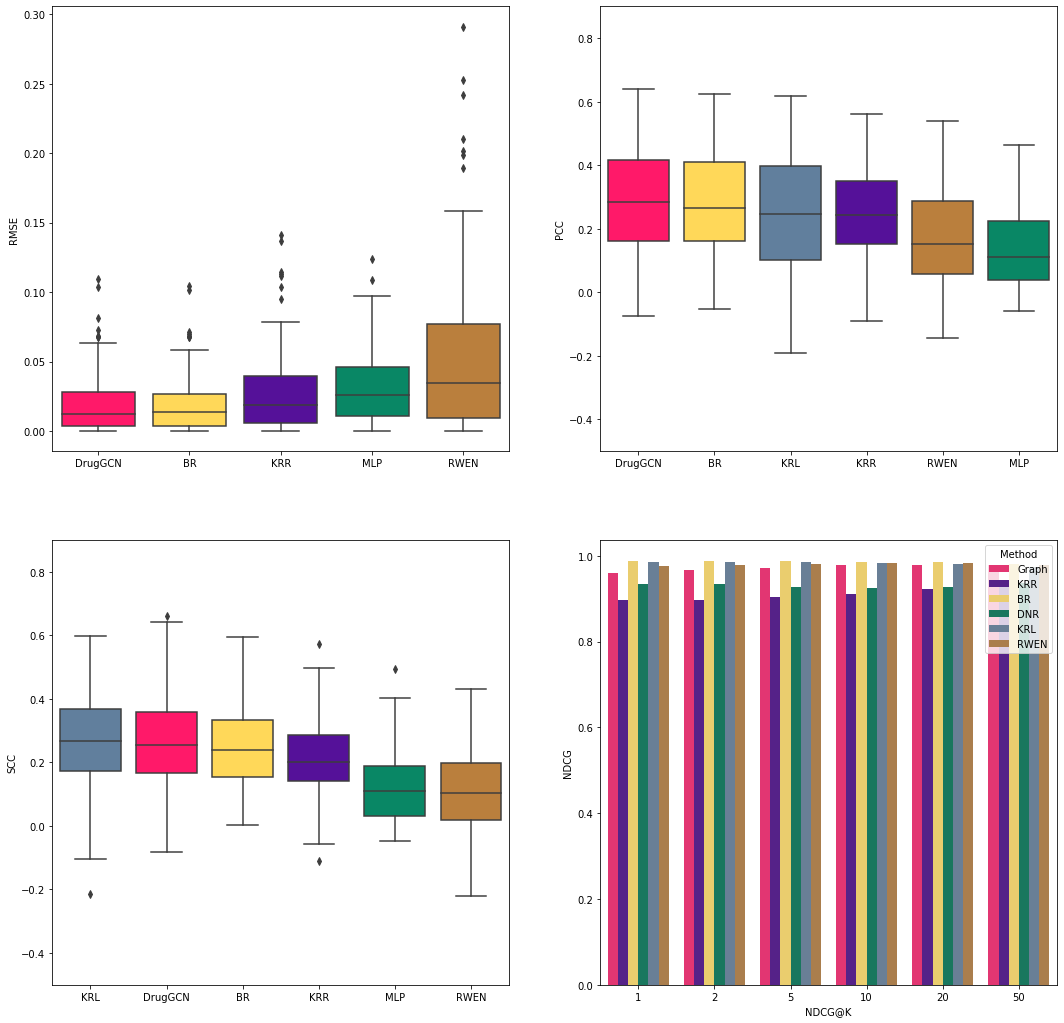

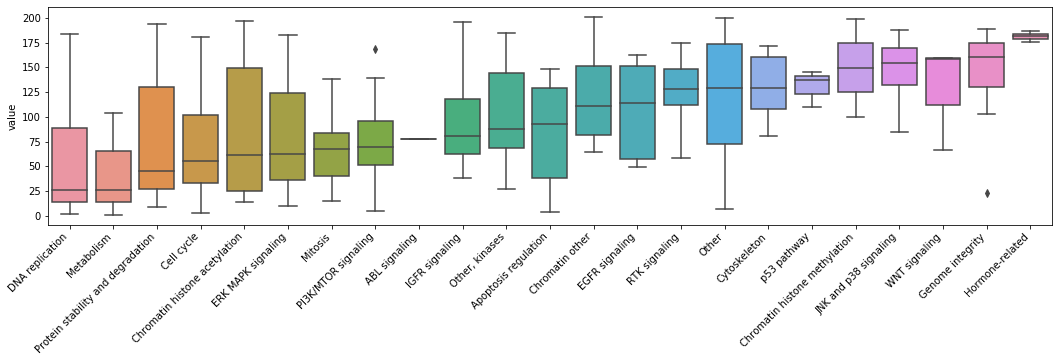

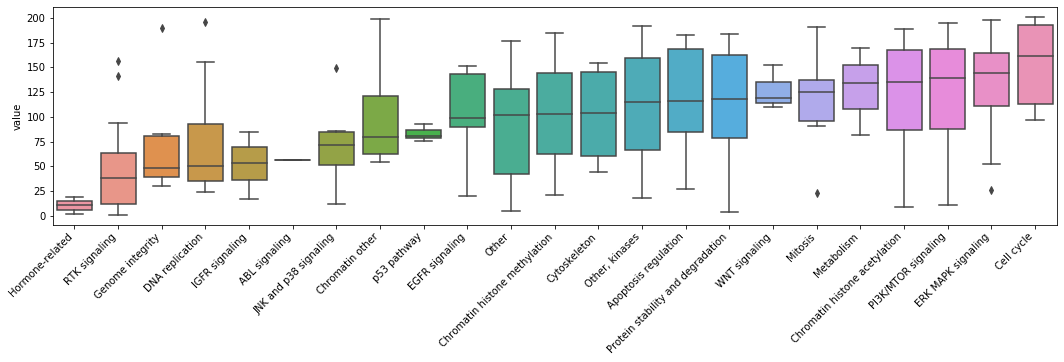

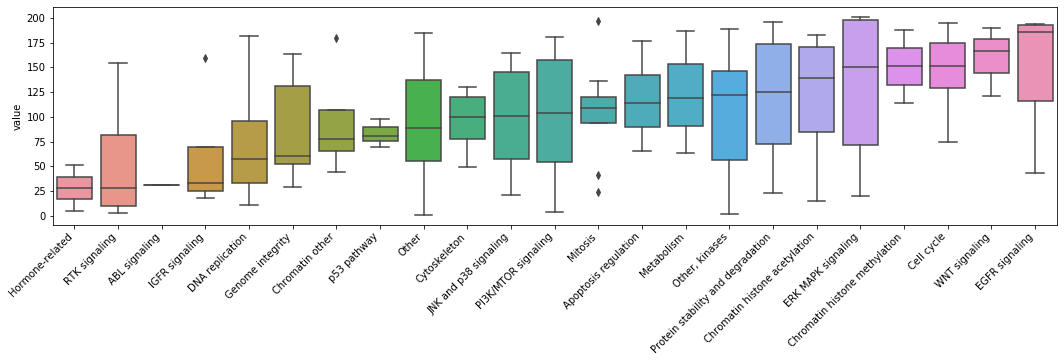

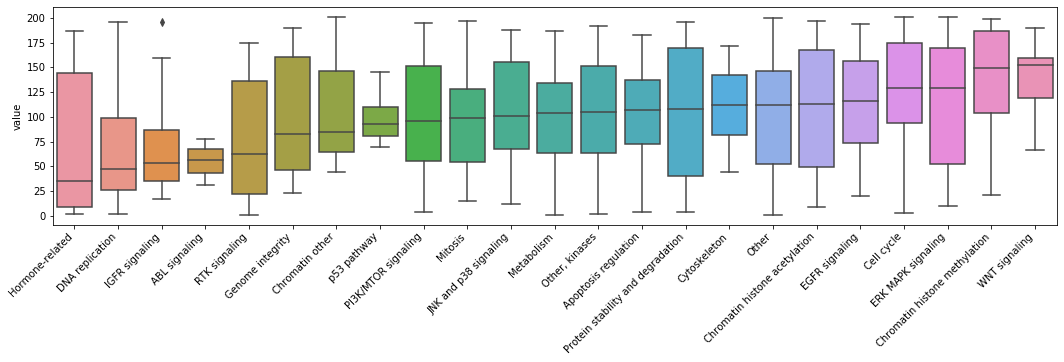

In [44]:
getPlot('result/210126/L1000+AUC/', ['L1000', 'AUC'], methods, colors)

L1000 ]  5 6 6 
 ['Graph', 'KRR', 'BR', 'DNR', 'RWEN', 'Graph', 'KRR', 'BR', 'DNR', 'KRL', 'RWEN', 'Graph', 'KRR', 'BR', 'DNR', 'KRL', 'RWEN']


UnboundLocalError: local variable 'k' referenced before assignment

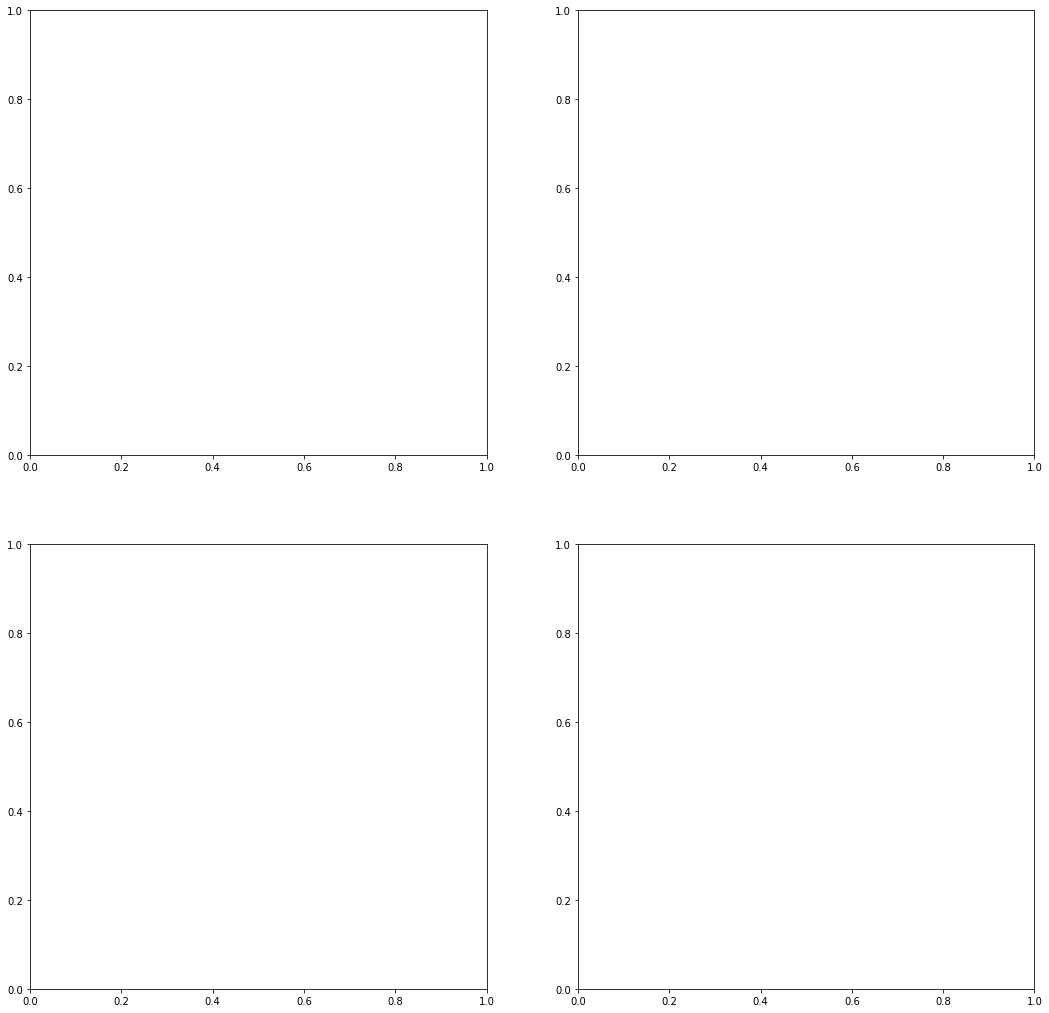

In [54]:
getPlot('result/210126/L1000+IC50/', ['L1000', 'IC50'], methods, colors)

VAR1000 ]  5 6 6 
 ['Graph', 'KRR', 'BR', 'DNR', 'RWEN', 'Graph', 'KRR', 'BR', 'DNR', 'KRL', 'RWEN', 'Graph', 'KRR', 'BR', 'DNR', 'KRL', 'RWEN']
[]
<class 'matplotlib.figure.Figure'>
     Graph  Graph  Graph
137  154.0    3.0    1.0
195  194.0   15.0    3.0
172  145.0    5.0    6.0
55   132.0   14.0   20.0
72   106.0    1.0   15.0
..     ...    ...    ...
146   59.0  192.0  199.0
164   37.0   80.0   29.0
159   28.0  149.0   91.0
5    187.0  125.0  128.0
165  111.0  193.0  200.0

[201 rows x 3 columns]


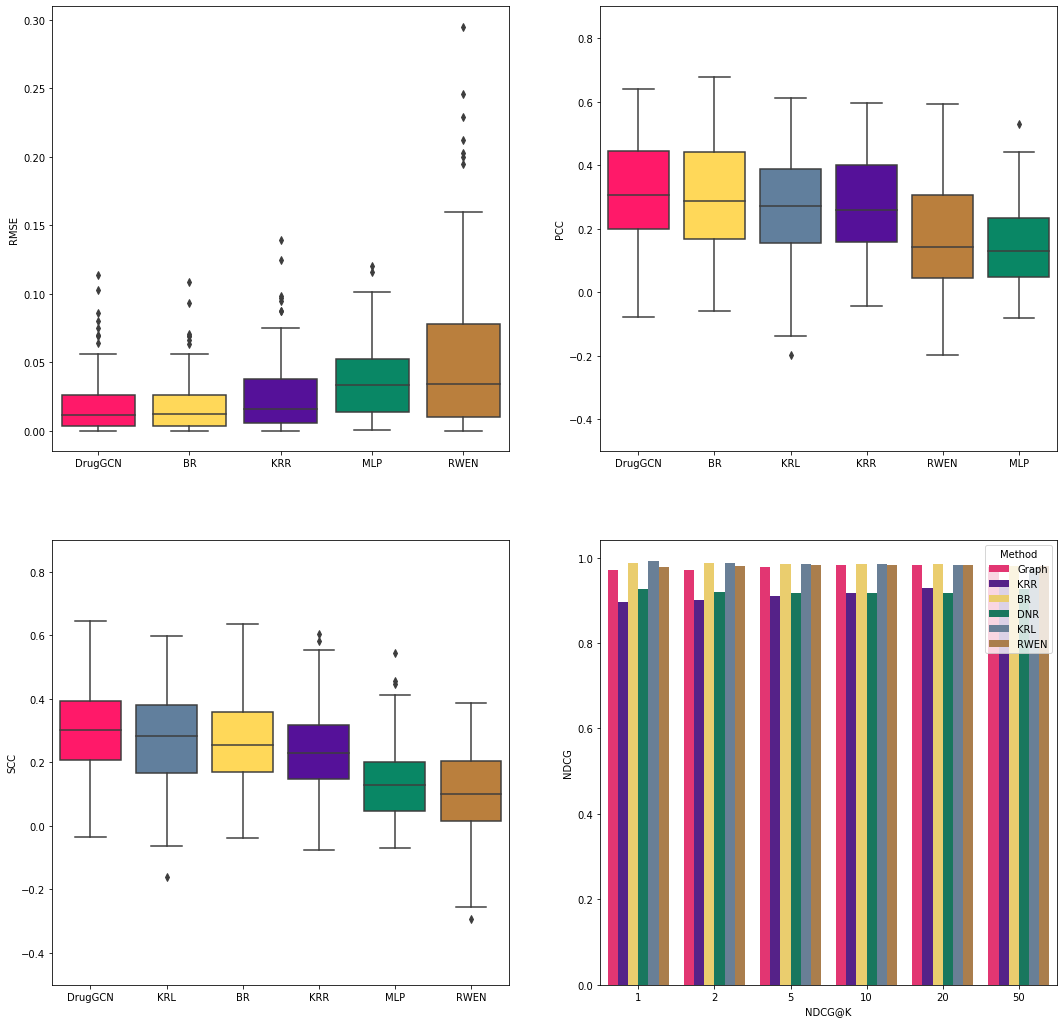

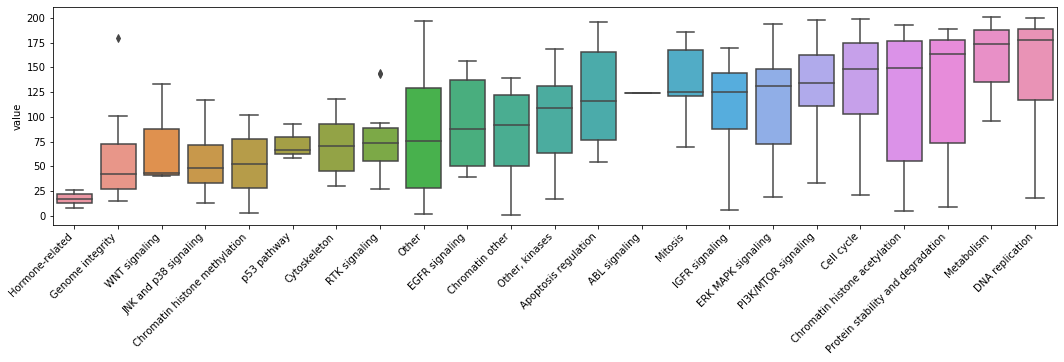

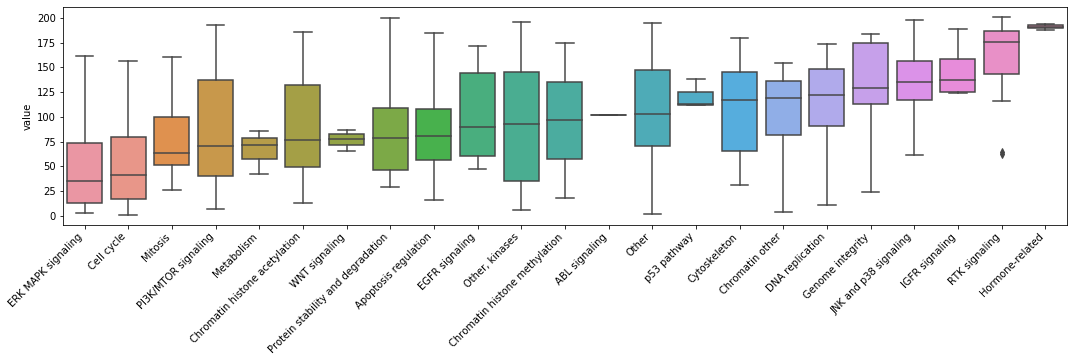

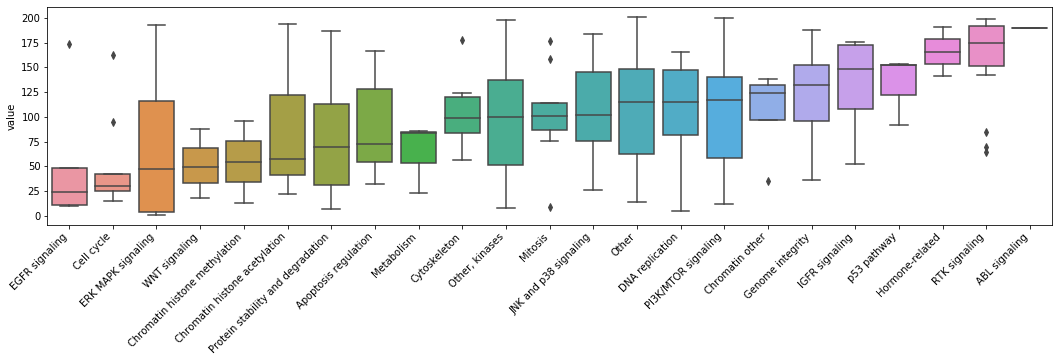

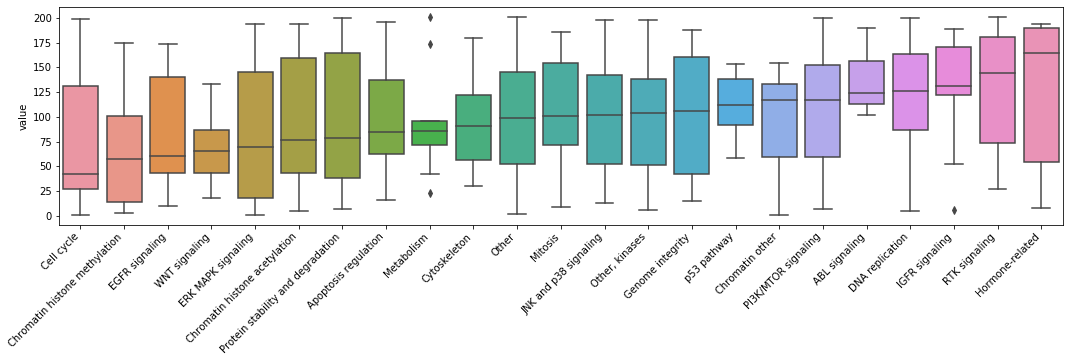

In [37]:
getPlot('result/210126/VAR1000+AUC/', ['VAR1000', 'AUC'], methods, colors)

VAR1000 ]  5 6 6 
 ['Graph', 'KRR', 'BR', 'DNR', 'RWEN', 'Graph', 'KRR', 'BR', 'DNR', 'KRL', 'RWEN', 'Graph', 'KRR', 'BR', 'DNR', 'KRL', 'RWEN']
[]
<class 'matplotlib.figure.Figure'>
     Graph  Graph  Graph
137  117.0    1.0    1.0
195  192.0    2.0    2.0
172  147.0   21.0    9.0
55   129.0    6.0    6.0
72   140.0    7.0    7.0
..     ...    ...    ...
146   79.0  193.0  194.0
164   61.0  184.0  179.0
159   41.0  200.0  200.0
5    155.0  199.0  199.0
165  123.0  198.0  197.0

[201 rows x 3 columns]


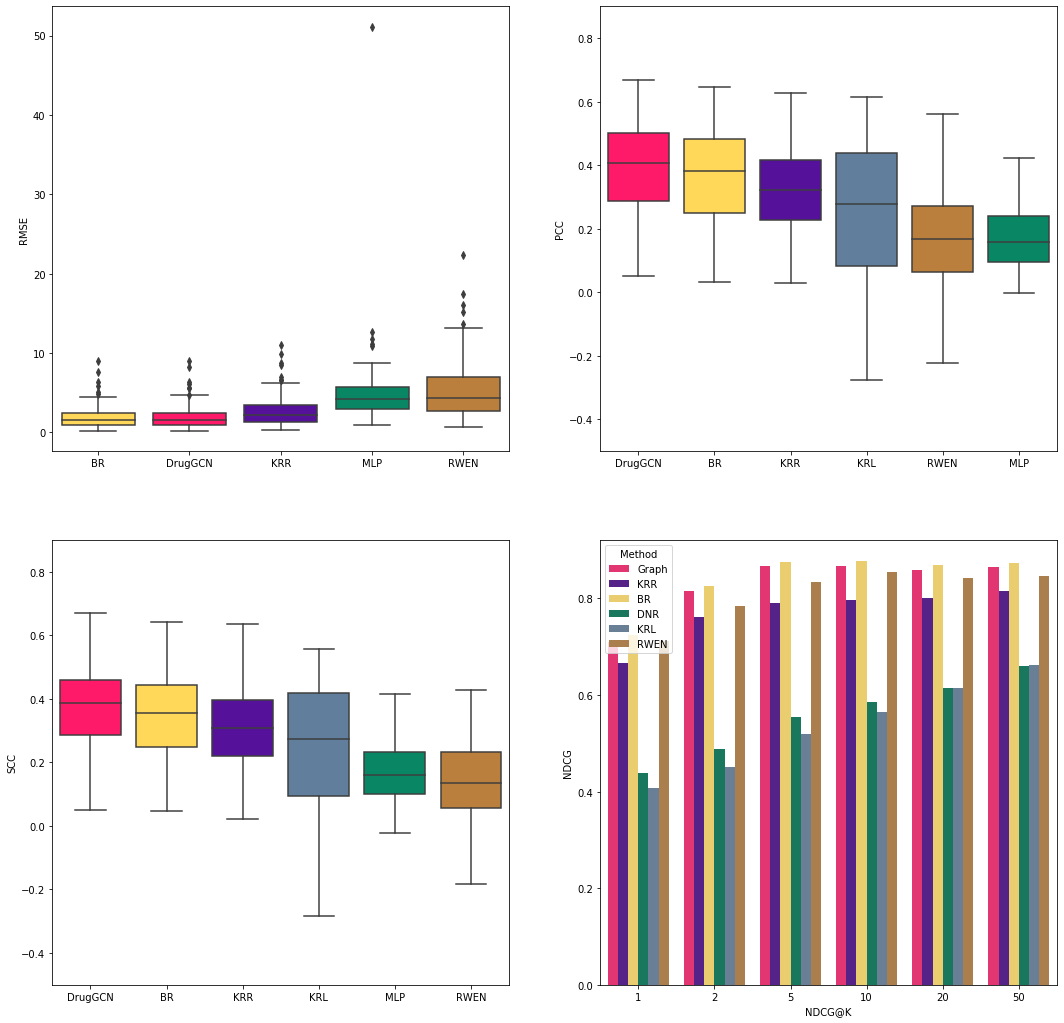

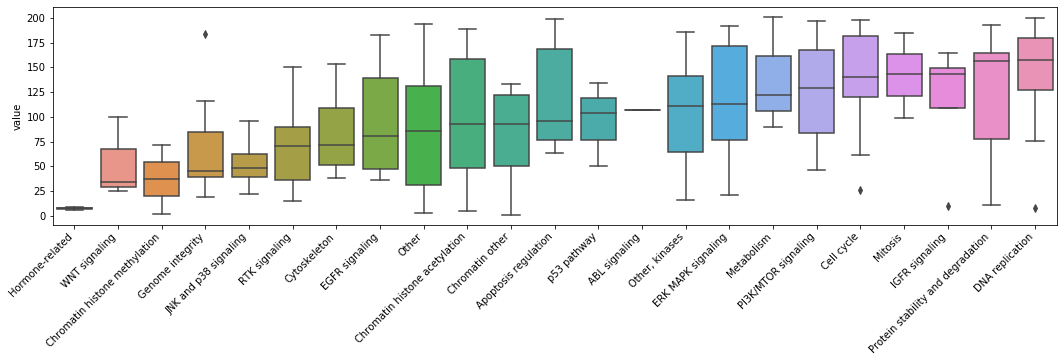

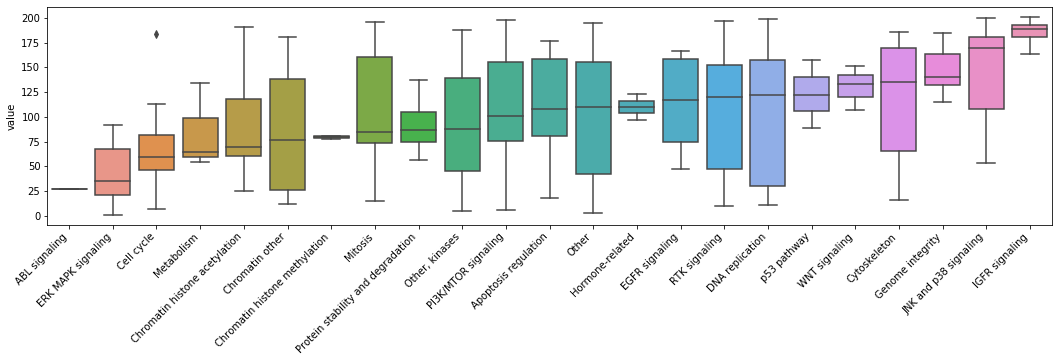

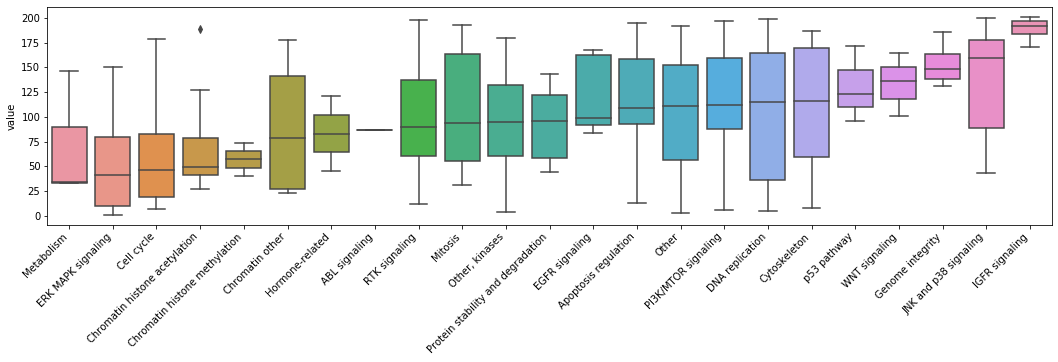

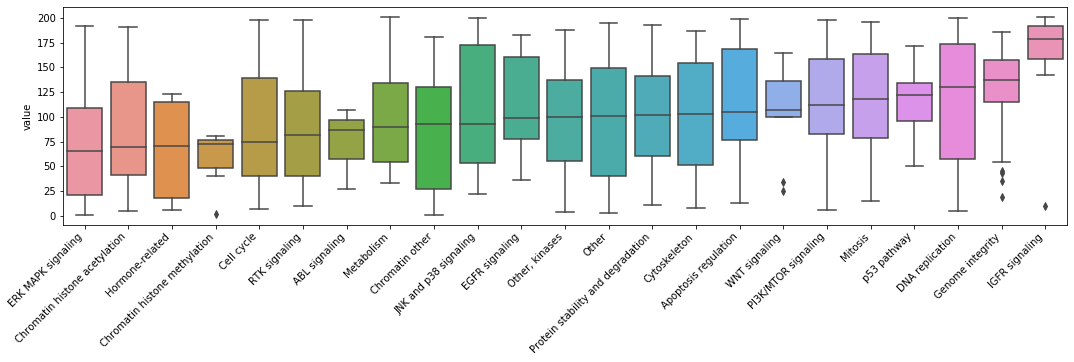

In [38]:
getPlot('result/210126/VAR1000+IC50/', ['VAR1000', 'IC50'], methods, colors)

# Number 4

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

In [83]:
with open('result/PATHWAY_DRUG.pickle', 'rb') as f:
    data = pickle.load(f)

DRUG = pd.read_csv('/data2/project/drugResponse/GDSC_DATASET_S1-S12/Table_S6_GDSC_Drug_response_IC50.csv').columns
DRUG_DICT = dict(zip(DRUG, list(range(0, len(DRUG)))))

count = 0
DRUG_NUMBER = []
for key, value in data.items():
    temp = []
    for name in value:
        temp.append(DRUG_DICT[name])
        count += 1
    DRUG_NUMBER.append(temp)

print("count ", count)

GROUP_NUMBER = dict(zip(data.keys(), DRUG_NUMBER))

count  201


In [88]:
data = pd.read_csv("result/210126/L1000+AUC/1.csv", index_col=0)
RMSE = list(range(0,4))
PCC = list(range(4,9))
SCC = list(range(9,14))

data.columns = np.array(data.columns.str.split('_').to_list()[:17])[:,1].tolist() + data.columns[-2:].to_list()
data1 = data.iloc[:,RMSE]
data2 = data.iloc[:,PCC]
data3 = data.iloc[:,SCC]
data1 = data1.rank().iloc[:,0]
data2 = data2.rank(ascending=False).iloc[:,0]
data3 = data3.rank(ascending=False).iloc[:,0]
# data1 = data1[data1.mean().sort_values().keys()]
# data2 = data2[data2.mean().sort_values(ascending=False).keys()]
# data3 = data3[data3.mean().sort_values(ascending=False).keys()]
# data1 = pd.melt(data1, var_name='Method')
# data2 = pd.melt(data2, var_name='Method')
# data3 = pd.melt(data3, var_name='Method')

In [496]:
df = pd.concat([data1, data2, data3, data.iloc[:,[0, 4, 9]]], axis=1)
df.columns = ['RMSE_RANK', 'PCC_RANK', 'SCC_RANK', 'RMSE', 'PCC', 'SCC']
df.to_csv('rank_evaluation210119.csv')

In [557]:
dfsum = pd.concat([df1.groupby('GROUP').median(), df2.groupby('GROUP').median(), df3.groupby('GROUP').median(), df.groupby('GROUP').median()], axis=1)
dfsum.columns = ['RMSE', 'PCC', 'SCC', 'SUM']
dfsum.to_csv('median.csv')

In [90]:
df = pd.concat([data1, data2, data3], axis=1)
df.columns = ['RMSE', 'PCC', 'SCC']
DRUG_GROUP = []
for index, value1 in df.iterrows():
    for key, value2 in GROUP_NUMBER.items():
        if index in value2:
            DRUG_GROUP.append(key)
df['GROUP'] = DRUG_GROUP
df = pd.melt(df, id_vars=['GROUP'])

RMSE

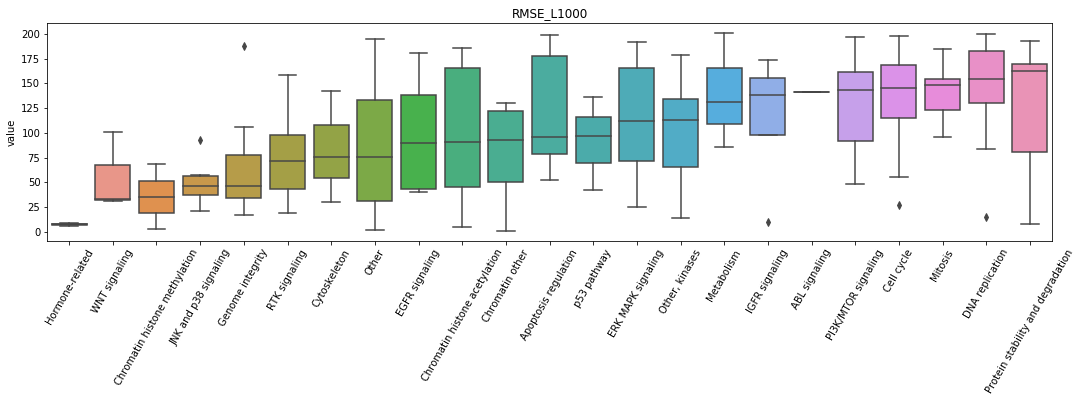

In [542]:
df1 = df[df.variable == 'RMSE']
group_order = df1.groupby('GROUP').median().sort_values(by='value').index
plt.figure(figsize=(18,4))
sns.boxplot(x='GROUP', y='value', data=df1, order=group_order)
plt.xticks(rotation=60)
plt.xlabel('')
plt.title('RMSE_L1000')
plt.show()

PCC

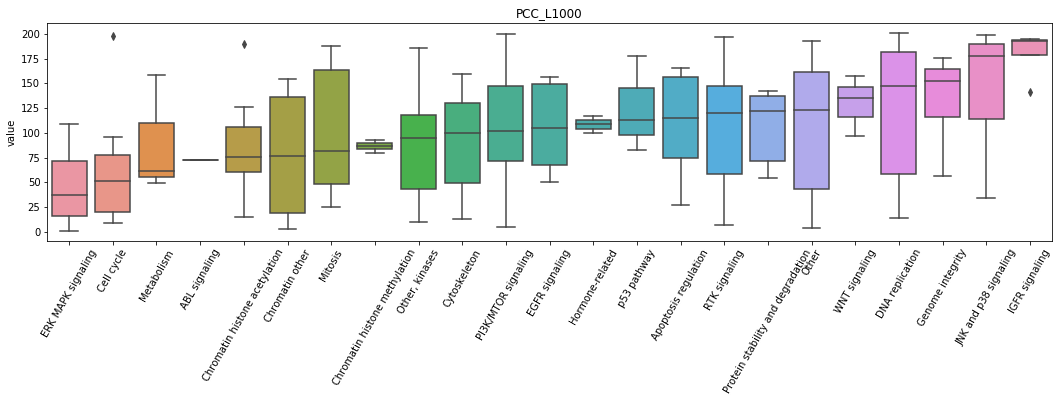

In [543]:
df2 = df[df.variable == 'PCC']
group_order = df2.groupby('GROUP').median().sort_values(by='value').index
plt.figure(figsize=(18,4))
sns.boxplot(x='GROUP', y='value', data=df2, order=group_order)
plt.xticks(rotation=60)
plt.xlabel('')
plt.title('PCC_L1000')
plt.show()

SCC

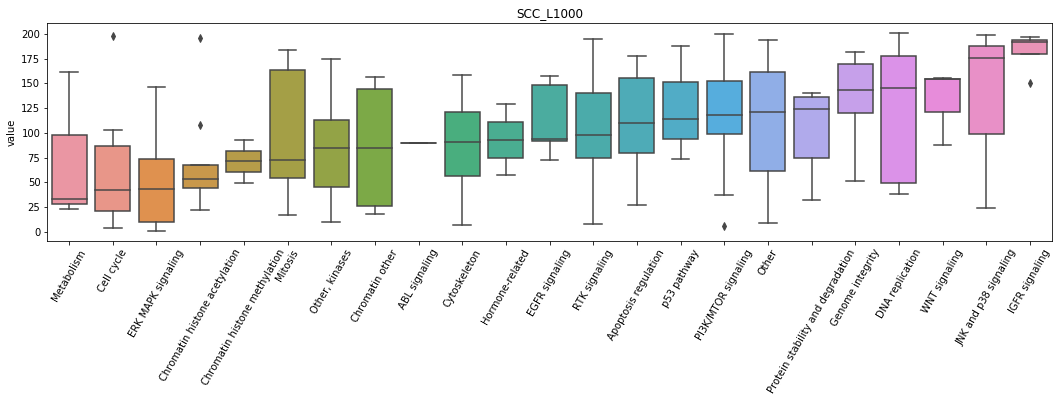

In [544]:
df3 = df[df.variable == 'SCC']
group_order = df3.groupby('GROUP').median().sort_values(by='value').index
plt.figure(figsize=(18,4))
sns.boxplot(x='GROUP', y='value', data=df3, order=group_order)
plt.xticks(rotation=60)
plt.xlabel('')
plt.title('SCC_L1000')
plt.show()

SUM

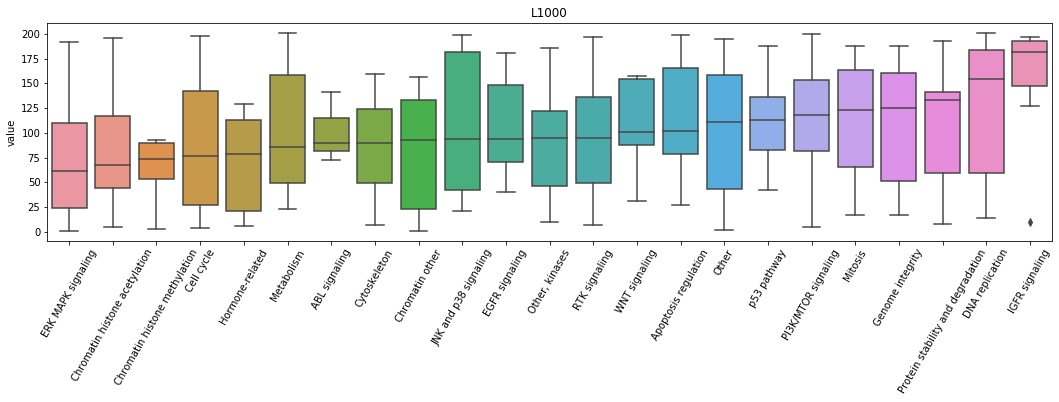

In [545]:
group_order = df.groupby('GROUP').median().sort_values(by='value').index
plt.figure(figsize=(18,4))
sns.boxplot(x='GROUP', y='value', data=df, order=group_order)
plt.xticks(rotation=60)
plt.xlabel('')
plt.title('L1000')
plt.show()